<center>
<h4>Diplodatos 2020 - FaMAF - UNC</h4>
<h1>Procesamiento de datos georeferenciados</h1>
<h3>Aprendizaje Supervisado</h3>
</center>

### Introducción

En el siguiente trabajo profundizaremos en el proceso de entrenamiento del modelo centrandonos en diferentes formas de seleccion de variables y tuning de hiperparametros.

Para esto construiremos sobre el conocimiento obtenido de los practicos anteriores.

In [44]:
import datetime

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb

from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
)
from sklearn.model_selection import train_test_split

from utils import (
    display_evaluation_errors,
    display_evaluation_table,
    display_markdown,
    show_qq_plot,
    show_residuals_plot
)

# Aprendizaje Automático Supervisado

## Carga y particion de los datos, en training y test

Antes de comenzar con el analisis debemos partir nuestro dataset en training y test sets.
Carguen el dataset utilizado en el practico anterior, realizen la particion y apliquen un pipeline de preprocesamiento en base a lo realizado en el practico anterior.

In [45]:
def transform_data(dataframe):
    """
    Transformar dataframe convirtiendo algunas variables no
    numéricas en numéricas y eliminando otras.
    """

    new_dataframe = dataframe.copy()
    
    # Eliminar índices, IDs y variables compuestas.
    new_dataframe.drop(
        columns=[
            'COD_ID', 'PAC_1', 'PAC_2', 'geometry', 'TR_S_geometry',
            'g_dispersion', 'TR_S_COD_ID', 'UNI_TR_S', 'TR_S_BARR_1',
            'TR_S_BARR_2'
        ],
        inplace=True,
        errors='ignore'
    )

    # Eliminar las siguientes variables dado que:
    # TR_S_BARR_3 == '' para todas las filas,
    # DIST == 46 para todas las filas,
    # CONF == 'RA' para todas las filas excepto una,
    # POSTO == 'PT' para todas las filas,
    # BANC == 0 para todas la filas,
    # MRT == 0 para todas la filas,
    # DESCR = '' para todas las filas,
    # SIT_ATIV = 'AT' para todas las filas excepto una,
    # TIP_UNID = 38 para todas las filas,
    # ATRB_PER = 1 para casi todas las filas,
    # CAP_CHA = 1 para casi todas las filas,
    # POS = 'PD' para casi todas las filas.
    new_dataframe.drop(
        columns=[
            'TR_S_BARR_3', 'DIST', 'CONF', 'POSTO', 'BANC', 'MRT', 'DESCR',
            'SIT_ATIV', 'TIP_UNID', 'ATRB_PER', 'CAP_CHA', 'POS'
        ],
        inplace=True,
        errors='ignore'
    )

    # Eliminar DIC (vamos a usar FIC).
    new_dataframe.drop(columns=['DIC'], inplace=True, errors='ignore')
    
    # Convertir CAP_ELO en una columna entera.
    new_dataframe.CAP_ELO = new_dataframe.CAP_ELO.replace({
        '05H': '50', '1H': '100', '2H': '200', '3H': '300', '5H': '500',
        '6K': '6000', '10K': '10000', '15K': '15000'
    }).astype('int')

    # Aplicar codificación one-hot para ARE_LOC.
    dummies = pd.get_dummies(new_dataframe.ARE_LOC)
    for dummy_col_name in dummies.columns:
        new_dataframe['ARE_LOC_is_{}'.format(dummy_col_name)] = dummies[dummy_col_name]

    # Algunas filas tienen varios valores de CNAE. Esto ocurre porque hay algunos
    # transformadores de distribución para los cuales existen dos o más
    # actividades económicas populares entre sus consumidores.
    # Como los casos son pocos, para simplificar el conjunto de datos, quedémonos
    # sólo con un valor de CNAE para cada fila que tenga múltiples valores.
    new_dataframe.CNAE = new_dataframe.CNAE.str.replace("'", "").str.strip('[]').apply(
        lambda value: value.split(' ')[-1]
    )

    # Aplicar codificación one-hot a CNAE (sólo valores más comunes).
    cnae_counts = new_dataframe.CNAE.value_counts()
    common_cnae_values = cnae_counts[:3].keys()
    dummies = pd.get_dummies(
        new_dataframe.CNAE.apply(
            lambda value: value if value in common_cnae_values else 'uncommon'
        )
    )
    for dummy_col_name in dummies.columns:
        new_dataframe['CNAE_is_{}'.format(dummy_col_name)] = dummies[dummy_col_name]

    # Calcular edades de conexión en días. Luego eliminaremos las columnas
    # DAT_CON y TR_S_DAT_CON porque no son numéricas.
    connection_age = datetime.datetime.now() - new_dataframe.DAT_CON
    new_dataframe['connection_age_days'] = connection_age.apply(
        lambda value: value.days
    )
    sub_connection_age = datetime.datetime.now() - new_dataframe.TR_S_DAT_CON
    new_dataframe['TR_S_connection_age_days'] = sub_connection_age.apply(
        lambda value: value.days
    )

    # Separar filas de acurdo a si el valor de PAC_3 se conoce o no. Luego
    # eliminaremos PAC_3 porque no es numérica.
    new_dataframe['PAC_3_known'] = new_dataframe.PAC_3.apply(
        lambda value: 0 if value == '0' else 1
    )

    # Aplicar codificación one-hot para FAS_CON_*.
    for col_name in ['FAS_CON_P', 'FAS_CON_S', 'FAS_CON_T']:
        dummies = pd.get_dummies(new_dataframe[col_name])
        for dummy_col_name in dummies.columns:
            new_dataframe['{}_is_{}'.format(col_name, dummy_col_name)] = dummies[dummy_col_name]

    # Aplicar codificación one-hot para ARE_LOC.
    dummies = pd.get_dummies(new_dataframe.CTMT)
    for dummy_col_name in dummies.columns:
        new_dataframe['CTMT_is_{}'.format(dummy_col_name)] = dummies[dummy_col_name]

    # Aplicar codificación one-hot para SUB.
    dummies = pd.get_dummies(new_dataframe.SUB)
    for dummy_col_name in dummies.columns:
        new_dataframe['SUB_is_{}'.format(dummy_col_name)] = dummies[dummy_col_name]

    # Aplicar codificación one-hot para TIP_TRAFO.
    dummies = pd.get_dummies(new_dataframe.TIP_TRAFO)
    for dummy_col_name in dummies.columns:
        new_dataframe['TIP_TRAFO_is_{}'.format(dummy_col_name)] = dummies[dummy_col_name]

    # Quitar columnas que no sean numéricas.
    new_dataframe.drop(
        columns=[
            'ARE_LOC', 'CNAE', 'DAT_CON', 'TR_S_DAT_CON', 'PAC_3', 'FAS_CON_P',
            'FAS_CON_S', 'FAS_CON_T', 'CTMT', 'SUB', 'TIP_TRAFO'
        ],
        inplace=True,
        errors='ignore'
    )

    return new_dataframe

In [46]:
dataframe = pd.read_csv(
    './data/curated_data.csv',
    sep='\t',
    parse_dates=['DAT_CON', 'TR_S_DAT_CON'],
    date_parser=lambda x: datetime.datetime.strptime(x, '%d/%m/%Y')
)

In [47]:
# Partir conjunto de datos en conjuntos de entrenamiento y validación.
X_train, X_valid, y_train, y_valid = train_test_split(
    transform_data(dataframe.drop(columns=['FIC'])),
    dataframe.FIC,
    test_size=0.3,
    random_state=42
)
X_train

,CONJ,MUN,ENE_01,ENE_02,ENE_03,ENE_04,ENE_05,ENE_06,ENE_07,ENE_08,...,CTMT_is_6_SEEST_1,CTMT_is_7_SEEST_1,SUB_is_SEAUA,SUB_is_SECON,SUB_is_SEEST,SUB_is_SEITI,SUB_is_SESAQ,SUB_is_SETMG,TIP_TRAFO_is_MT,TIP_TRAFO_is_T
4984,15602,2806305,2703,2565,2463,2790,2656,2551,2759,2074,...,0,0,0,0,1,0,0,0,0,1
5798,15600,2805109,519,410,386,403,664,649,802,805,...,0,0,1,0,0,0,0,0,1,0
5339,15602,2802106,23121,26566,22821,25358,26446,23078,22513,22757,...,0,0,0,0,1,0,0,0,0,1
4963,15602,2802106,88,94,75,75,114,146,68,72,...,0,0,0,0,1,0,0,0,1,0
7354,15601,2803005,26,34,29,22,15,11,0,10,...,0,0,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5734,15600,2800407,117906,108980,116996,114362,117782,112401,115085,119218,...,0,0,1,0,0,0,0,0,0,1
5191,15602,2802106,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,1,0
5390,15602,2802106,0,0,0,0,236,1247,948,1009,...,1,0,0,0,1,0,0,0,0,1
860,12737,2807402,433,384,438,376,345,389,349,419,...,0,0,0,0,0,0,1,0,1,0


## Baseline

En este practico estaremos utilizando nuevamente un modelo XGBoost, ya que nos permite obtener buenos resultados de manera rapida y ademas cuenta con numerosos hiperparametros que podremos ajustar para optimizar su performance.

Para comenzar definiremos un baseline utilizando los hiperparametros por defecto.

Entrene un modelo XGBoost basico, utilizando los hiperparametros por defecto, seleccione una metrica de error y presente el resultado.

In [48]:
regressor = xgb.XGBRegressor(random_state=42)

regressor.fit(X_train, y_train)

y_train_pred = regressor.predict(X_train)
y_valid_pred = regressor.predict(X_valid)

display_evaluation_errors(y_train, y_train_pred, y_valid, y_valid_pred)
display_evaluation_table(y_valid, y_valid_pred)

,R squared,Mean absolute error,Mean squared error
Training,0.950245,0.636998,0.743569
Validation,0.729571,1.473470,4.014440


,Prediction,Real,Error
5014,4.950160,5.0,0.049840
8568,4.598640,3.0,1.598640
3002,4.500922,11.0,6.499078
2673,2.561962,2.0,0.561962
2777,0.899992,0.0,0.899992
1536,9.686748,8.0,1.686748
4288,5.202105,6.0,0.797895
4715,5.779987,5.0,0.779987
3213,6.322245,3.5,2.822245
8066,4.976450,5.0,0.023550


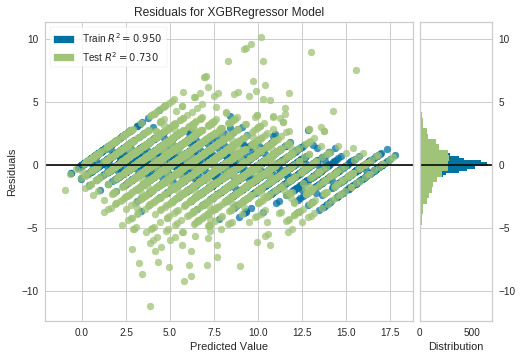

/home/javiergallo/MyMess/diplodatos/mentoria/trabajo/AprendizajeAutomatico-/utils.py:60: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  qq_plot.show()


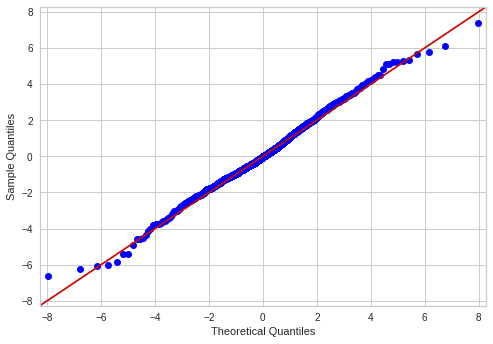

In [49]:
show_residuals_plot(regressor, X_train, y_train, X_valid, y_valid)
show_qq_plot(y_valid, y_valid_pred)

## Seleccion de variables

La seleccion de variables es un proceso a traves del cual se intentan distinguir las variables que aportan valor de prediccion de las que no, y de esta forma quedarnos solamente con aquellas que impacten positivamente en nuestro algoritmo.

Esto nos traera multiples beneficios, al simplificar el modelo reducimos el riesgo de overfitting, disminuimos el costo computacional de entrenamiento y prediccion y reducimos el ruido introducido por las variables de poco valor.

Existen diversas formas de llevar a cabo este proyecto:
  - Filtros o Reglas: Se especifica alguna metrica o valor estadistico y se eliminan las features que no lo cumplan. Ej: Correlacion maxima entre variables, correlacion minima con la variable de salida, colinealidad entre variables, cantidad de valores nulos.

  - Wrapper Base: Son metodos que se plantean como problemas de busqueda, como por ejemplo la eliminacion recursiva de variables.

  - Metodos embebidos: Algunos metodos de estimacion poseen procesos internos de clasificacion de variables, en donde se le asigna un nivel de importancia a cada una de ellas que puede luego ser utilizado para conocer su importancia. Ejemplos clasicos son los coeficientes de la regresion de Lasso o el feature importance en implementaciones basadas en arboles como XGBoost.

En base al baseline calculado en el punto anterior comience seleccionando las 50 variables mas importantes en base a la informacion provista por XGBoost.

In [50]:
most_important_col_names = X_train.columns[
    regressor.feature_importances_.argsort()[-50:][::-1]
]
most_important_col_names

Index(['TR_S_connection_age_days', 'SUB_is_SEITI', 'FAS_CON_P_is_AB',
       'CTMT_is_1_SETMG_1', 'ARE_LOC_is_NU', 'CTMT_is_3_SEEST_1',
       'CTMT_is_5_SEEST_1', 'ENDNODE', 'CTMT_is_3_SESAQ_1',
       'CTMT_is_3_SETMG_1', 'CTMT_is_2_SEEST_1', 'CTMT_is_2_SETMG_1',
       'CTMT_is_1_SEITI_1', 'CTMT_is_2_SECON_1', 'CTMT_is_2_SEITI_1',
       'dist_to_trs_dijkstra', 'CTMT_is_4_SEITI_1', 'CTMT_is_3_SEAUA_1',
       'CTMT_is_6_SEEST_1', 'TR_S_POT_NOM', 'CTMT_is_2_SESAQ_1',
       'CTMT_is_3_SEITI_1', 'MUN', 'TR_S_DIST', 'NODE', 'PER_FER',
       'CTMT_is_4_SEAUA_1', 'CTMT_is_3_SECON_1', 'TR_S_MUN', 'CNAE_is_0',
       'connection_age_days', 'PAC_3_known', 'ENE_11', 'ENE_03', 'POT_NOM',
       'CTMT_is_1_SESAQ_1', 'FAS_CON_P_is_BC', 'TR_S_ENES_01', 'ENE_02',
       'ENE_10', 'n_close_con', 'ENE_07', 'ENE_06', 'ENE_04', 'TR_S_ENES_04',
       'ENE_09', 'TAP', 'ENE_05', 'TEN_LIN_SE', 'CAP_ELO'],
      dtype='object')

In [51]:
# **IMPORTANTE**: ver colinealidad entre varaibles, que no haya demasiada.
# https://www.analyticsvidhya.com/blog/2020/03/what-is-multicollinearity/

A partir del punto anterior calcule el error para diferentes cantidades de variables, realize un grafico de numero de variables vs error, seleccione el valor de mejor performance y justique.

In [52]:
n_col_vs_error_data = {
    'n_cols': [],
    'r2_score': [],
    'mean_abs_error': [],
    'mean_squared_error': []
}
col_names = []
for col_name in most_important_col_names:
    col_names.append(col_name)
    
    regressor = xgb.XGBRegressor(random_state=42)

    regressor.fit(X_train[col_names], y_train)

    y_valid_pred = regressor.predict(X_valid[col_names])
    
    n_col_vs_error_data['n_cols'].append(len(col_names))
    n_col_vs_error_data['r2_score'].append(r2_score(y_valid, y_valid_pred))
    n_col_vs_error_data['mean_abs_error'].append(mean_absolute_error(y_valid, y_valid_pred))
    n_col_vs_error_data['mean_squared_error'].append(mean_squared_error(y_valid, y_valid_pred))

n_col_vs_error_df = pd.DataFrame(n_col_vs_error_data)
n_col_vs_error_df

,n_cols,r2_score,mean_abs_error,mean_squared_error
0,1,0.097773,2.955173,13.393316
1,2,0.097773,2.955173,13.393316
2,3,0.156769,2.835732,12.517539
3,4,0.157129,2.844425,12.512196
4,5,0.197735,2.764090,11.909410
5,6,0.215072,2.735946,11.652046
6,7,0.220382,2.713766,11.573215
7,8,0.366154,2.346793,9.409267
8,9,0.366058,2.347065,9.410699
9,10,0.365971,2.347369,9.411997


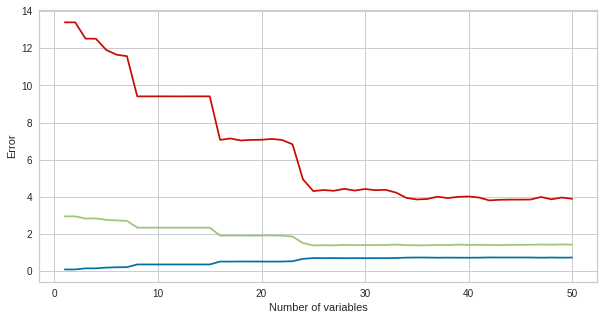

In [53]:
plt.figure(figsize=(10, 5))
sns.lineplot(data=n_col_vs_error_df, x='n_cols', y='r2_score')
sns.lineplot(data=n_col_vs_error_df, x='n_cols', y='mean_abs_error')
sns.lineplot(data=n_col_vs_error_df, x='n_cols', y='mean_squared_error')
plt.xlabel('Number of variables')
plt.ylabel('Error');

**TODO: JUSTIFICACIÓN!**

Genere un nuevo dataset que contenga solamente las variables seleccionadas.

In [55]:
selected_col_names = most_important_col_names[:35]
selected_col_names

Index(['TR_S_connection_age_days', 'SUB_is_SEITI', 'FAS_CON_P_is_AB',
       'CTMT_is_1_SETMG_1', 'ARE_LOC_is_NU', 'CTMT_is_3_SEEST_1',
       'CTMT_is_5_SEEST_1', 'ENDNODE', 'CTMT_is_3_SESAQ_1',
       'CTMT_is_3_SETMG_1', 'CTMT_is_2_SEEST_1', 'CTMT_is_2_SETMG_1',
       'CTMT_is_1_SEITI_1', 'CTMT_is_2_SECON_1', 'CTMT_is_2_SEITI_1',
       'dist_to_trs_dijkstra', 'CTMT_is_4_SEITI_1', 'CTMT_is_3_SEAUA_1',
       'CTMT_is_6_SEEST_1', 'TR_S_POT_NOM', 'CTMT_is_2_SESAQ_1',
       'CTMT_is_3_SEITI_1', 'MUN', 'TR_S_DIST', 'NODE', 'PER_FER',
       'CTMT_is_4_SEAUA_1', 'CTMT_is_3_SECON_1', 'TR_S_MUN', 'CNAE_is_0',
       'connection_age_days', 'PAC_3_known', 'ENE_11', 'ENE_03', 'POT_NOM'],
      dtype='object')

In [56]:
X_train = X_train[selected_col_names]
X_valid = X_valid[selected_col_names]
X_train

,TR_S_connection_age_days,SUB_is_SEITI,FAS_CON_P_is_AB,CTMT_is_1_SETMG_1,ARE_LOC_is_NU,CTMT_is_3_SEEST_1,CTMT_is_5_SEEST_1,ENDNODE,CTMT_is_3_SESAQ_1,CTMT_is_3_SETMG_1,...,PER_FER,CTMT_is_4_SEAUA_1,CTMT_is_3_SECON_1,TR_S_MUN,CNAE_is_0,connection_age_days,PAC_3_known,ENE_11,ENE_03,POT_NOM
4984,3080,0,0,0,1,0,1,12988,0,0,...,100,0,0,2802106,1,788,0,2960,2463,15.0
5798,3566,0,1,0,1,0,0,118082,0,0,...,85,0,0,2800407,1,3658,1,369,386,15.0
5339,3080,0,0,0,0,0,0,10170,0,0,...,220,0,0,2802106,1,3665,0,27002,22821,45.0
4963,3080,0,1,0,1,1,0,7640,0,0,...,50,0,0,2802106,1,2404,1,96,75,5.0
7354,11601,1,1,0,1,0,0,48689,0,0,...,85,0,0,2803005,1,3658,1,42,29,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5734,3566,0,0,0,0,0,0,118079,0,0,...,440,0,0,2800407,1,3658,0,114871,116996,112.5
5191,3080,0,1,0,1,0,0,150,0,0,...,50,0,0,2802106,1,1589,1,8,0,5.0
5390,3080,0,0,0,0,0,0,13867,0,0,...,220,0,0,2802106,1,817,0,1383,0,45.0
860,12332,0,1,0,1,0,0,39536,0,0,...,50,0,0,2807402,1,3659,1,436,438,5.0


## Tuning de hiperparametros

Existen varias formas de hacer tuneo de hiperparametros, la mejor opcion dependera del costo computacional del modelo y las limitacion en tiempos o recursos que tengamos.

Lo primero que debemos definir es un espacio de busqueda, en nuestro caso el modelo cuenta con numerosos hiperparametros, pero utilizarlos a todos representaria un espacio de busqueda muy grande y por ende un costo computacional muy grande.

Consultando la documentacion seleccione entre 3 y 5 parametros de XGBoost y defina un espacio de busqueda que pueda ser utilizado por sklearn.







### Random search

Una opcion es una busqueda de hiperparametros sobre un espacio de forma aleatorea. Esta opcion en un principio no nos garantiza encontrar la mejor combinacion sin embargo tiene la ventaja de necesitar muchas menos iteraciones.

Utilize la funcion de sklearn.model_selection.RandomizedSearchCV para realizar una busqueda de hiperpatametros.

In [29]:
# TODO: Brandon.

### Grid search

Cuando queremos agotar las posibilidades de busqueda podemos realizar una busqueda de todas las combinaciones de parametros posibles, esto se denomina Grid Search.

Utilize la funcion de sklearn.model_selection.GridSearchCV para realizar una busqueda de hiperpatametros.

In [30]:
# TODO: Guille.

### Metodos Avanzados, Optimizacion Bayesiana.

Existen metodos mas avanzados de busqueda de hiperparametros, uno de ellos utiliza metodos bayesianos para dirigir la busqueda de modo que esta se realize de manera mas eficiente.

Una forma de implementar esto facilmente en python es utilizando la libreria hyperopt. A continuacion se presenta un template para utilizar las misma.

Pueden encontrar mas informacion en: 
https://hyperopt.github.io/hyperopt/?source=post_page


In [115]:
# Definir espacio de búsqueda.
space = {
    'n_estimators': 10 + hp.randint('n_estimators', 20),
    'max_depth': 10 + hp.randint('max_depth', 20),
    'learning_rate': hp.uniform('learning_rate', 0.1, 1.0),
    'booster' : hp.choice('booster', ['gbtree', 'dart']),
}


def objective(space):
    """
    Función objetivo (para optimizar).
    """
    regressor = xgb.XGBRegressor(**space)

    evaluation = [(X_train, y_train), (X_valid, y_valid)]

    regressor.fit(
        X_train,
        y_train,
        eval_set=evaluation,
        eval_metric='mae',
        early_stopping_rounds=10,
        verbose=False,
    )

    y_valid_pred = regressor.predict(X_valid)
    error = mean_absolute_error(y_valid, y_valid_pred)

    return {
        'loss': error,
        'status': STATUS_OK,
        'regressor': regressor
    }


# Correr optimización
trials = Trials()
best_hyperparams = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=100,
    trials=trials
)

print('The best hyperparameters are:\n')
print(best_hyperparams)

100%|██████████| 100/100 [00:24<00:00,  4.02trial/s, best loss: 1.2849168516217537]
The best hyperparameters are:

{'booster': 1, 'learning_rate': 0.15691419568626508, 'max_depth': 17, 'n_estimators': 17}


,R squared,Mean absolute error,Mean squared error
Training,0.996418,0.135581,0.053537
Validation,0.733450,1.284917,3.956864


,Prediction,Real,Error
1536,10.200596,8.0,2.200596
1180,3.452471,3.0,0.452471
5153,4.837574,4.0,0.837574
4038,8.436131,9.0,0.563869
6403,0.735994,1.0,0.264006
222,11.456005,16.0,4.543995
2201,8.673420,9.0,0.326580
4180,7.243186,9.0,1.756814
5830,7.329403,7.0,0.329403
6442,0.994606,1.0,0.005394


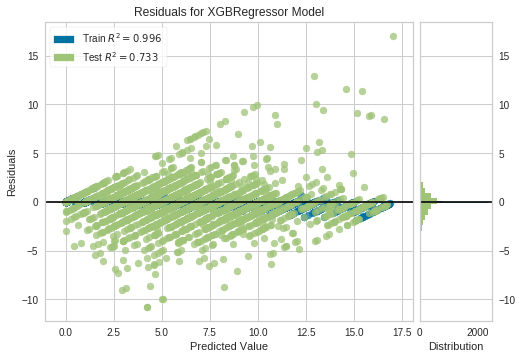

/home/javiergallo/MyMess/diplodatos/mentoria/trabajo/AprendizajeAutomatico-/utils.py:60: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  qq_plot.show()


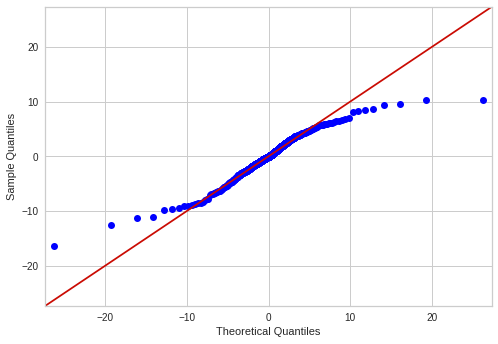

In [117]:
regressor = trials.best_trial['result']['regressor']
y_train_pred = regressor.predict(X_train)
y_valid_pred = regressor.predict(X_valid)

display_evaluation_errors(y_train, y_train_pred, y_valid, y_valid_pred)
display_evaluation_table(y_valid, y_valid_pred)
show_residuals_plot(regressor, X_train, y_train, X_valid, y_valid)
show_qq_plot(y_valid, y_valid_pred)

## Comparacion

Realize una tabla comparativa de los resultados obtenidos entre:

- Modelo con hiperparametros por default sin seleccion de variables
- Modelo con hiperparametros por default con seleccion de variables
- Modelo con optimizacion de hiperparametros por cada metodo

En base a los resultados exponga sus observacion relacionada tanto con la performance del modelo como de los tiempos de ejecucion.

# Aprendizaje Automático No Supervisado

### Clusterizacion como metodo de generacion de features

Vamos a utilizar a la clusterización como método de generacion de features y posteriormente vamos a correr los modelos de predicción.

Basandose en el algoritmo de KMeans, aplique el metodo de codo (elbow) para estimar la cantidad optima de clusters. 

(Opcional) En caso de que la clusterizacion este demorando mucho en ejecutarse puede aplicarse PCA en un paso previo para disminuir las dimensiones.

Realizar la predicción del cluster del conjunto de validación.




Integre los clusters al dataset de training y vuelva a correr a entrenar el algoritmo de deteccion de mejor rendimiento.

Compare los resultados obtenidos.